# 발전, 심화, 확장

- Transformer 기반 예측 모델
- Variational Autoencoder(VAE) 추가
- 다양한 데이터 소스와 실시간 시스템에 쉽게 확장할 수 있는 구조

In [28]:
import os
import io
import zipfile
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 기존 데이터 다운로드 및 전처리 함수

In [29]:
def download_and_extract_data(url, extract_path='.'):
    # 파일 다운로드 및 압축 해제
    zip_path = os.path.join(extract_path, 'AirQualityUCI.zip')
    if not os.path.exists(zip_path):
        print("데이터 다운로드 중...")
        urllib.request.urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print('압축 해제 완료.')
    
def load_and_preprocess_data(file_path):
    # AirQualityUCI 데이터셋은 세미콜론(;) 구분, 소수점은 콤마(,) 사용
    df = pd.read_csv(file_path, sep=';', decimal=',')
    # 마지막 두 컬럼은 불필요하므로 제거
    df = df.iloc[:, :-2]
    
    # 'Date'와 'Time'을 합쳐 datetime 인덱스로 변환
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'].str.replace('.', ':'), dayfirst=True, errors='coerce')
    df = df.dropna(subset=['Datetime'])
    df = df.set_index('Datetime')
    df = df.sort_index()
    
    # 결측치 처리: AirQualityUCI에서는 -200 값이 결측치를 의미
    df.replace(-200, np.nan, inplace=True)
    df.fillna(method='ffill', inplace=True)
    
    # 필요한 컬럼 선택
    # 센서 데이터: 'CO(GT)', 'C6H6(GT)'
    # 외부 데이터(기상정보): 'T' (온도), 'RH' (상대습도)
    df = df[['CO(GT)', 'C6H6(GT)', 'T', 'RH']]
    
    # 간단한 스케일링: 이후 모델 입력을 위해 StandardScaler 적용
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
    
    return df_scaled, scaler

In [30]:
# 시계열 데이터 생성 (슬라이딩 윈도우)
def create_sequence(data, target_col, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length].values  # 여러 변수 입력
        target = data.iloc[i+seq_length][target_col]  # 예측 대상 변수
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

# PyTorch Dataset

In [31]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.X = torch.tensor(sequences, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 예측모델: LSTMForecast

In [32]:
class LSTMForecast(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMForecast, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x shape: (batch, seq_length, input_dim)
        lstm_out, _ = self.lstm(x)
        # 마지막 시점의 출력을 사용
        out = self.fc(lstm_out[:, -1, :])
        return out

## [추가] 예측 모델: Transformer 기반 Forecasting

In [33]:
# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)
    
class TransformerForecast(nn.Module):
    def __init__(self, input_dim, d_model=32, nhead=4, num_layers=2, output_dim=1, dropout=0.1):
        super(TransformerForecast, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, d_model*2, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc_out = nn.Linear(d_model, output_dim)
        
    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        x = self.input_proj(x)  # (batch, seq_len, d_model)
        x = self.pos_encoder(x)
        x = x.transpose(0, 1)  # Transformer expects (seq_len, batch, d_model)
        x = self.transformer_encoder(x)
        x = x[-1]  # 마지막 time step 사용
        out = self.fc_out(x)
        return out

# 이상치 감지 모델: AutoEncoder

In [34]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.ReLU()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## [추가] 이상치 감지모델: Variational Autoencoder (VAE)

In [35]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super(VariationalAutoencoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        self.fc3 = nn.Linear(64, input_dim)
        
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h2 = F.relu(self.fc2(z))
        return F.relu(self.fc3(h2))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar
    
def vae_loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss

## 모델 학습 및 평가 함수

In [36]:
def train_model(model, dataloader, num_epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(num_epochs):
        epoch_losses = []
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(epoch_losses):.4f}')
    return model

def evaluate_model(model, dataloader):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            outputs = model(X_batch)
            predictions.extend(outputs.squeeze().cpu().numpy())
            targets.extend(y_batch.cpu().numpy())
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")
    return predictions, targets

def train_autoencoder(model, dataloader, num_epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(num_epochs):
        epoch_losses = []
        for X_batch, _ in dataloader:
            # Autoencoder: 입력 자체를 재구성
            optimizer.zero_grad()
            outputs = model(X_batch.view(X_batch.size(0), -1))
            loss = criterion(outputs, X_batch.view(X_batch.size(0), -1))
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        print(f"[Autoencoder] Epoch: {epoch+1}/{num_epochs}, Loss: {np.mean(epoch_losses):.4f}")
    return model

def train_vae(model, dataloader, num_epochs=10, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for X_batch, _ in dataloader:
            optimizer.zero_grad()
            X_flat = X_batch.view(X_batch.size(0), -1)
            recon, mu, logvar = model(X_flat)
            loss = vae_loss_function(recon, X_flat, mu, logvar)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"[VAE] Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.4f}")
    return model

## 메인 실행 예시

In [23]:
if __name__ == '__main__':
    # 데이터 다운로드 및 전처리
    data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip"
    download_and_extract_data(data_url)
    data_file = 'AirQualityUCI.csv'
    data_scaled, scaler = load_and_preprocess_data(data_file)
    
    # 시계열 sequence 생성 (지난 10시간의 데이터를사용해 'CO(GT)' 예측)
    sequence_length = 10
    target_column = 'CO(GT)'
    X_seq, y_seq = create_sequence(data_scaled, target_column, seq_length=sequence_length)
    
    # 데이터 분할 (학습: 70%, 테스트: 30%)
    split_idx = int(len(X_seq) * 0.7)
    X_train, y_train = X_seq[:split_idx], y_seq[:split_idx]
    X_test, y_test = X_seq[split_idx:], y_seq[split_idx:]
    
    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    input_dim = X_train.shape[2]  # 센서 + 외부 변수 개수
    batch_size = 16
    seq_length = 10
    hidden_dim = 32
    num_layers = 2
    output_dim = 1
    
    # 예측 모델 Transformer
    transformer_model = TransformerForecast(input_dim, d_model=32, nhead=4, num_layers=num_layers, output_dim=output_dim)
    
    print('\n[예측 모델(Transformer) 학습]')
    transformer_model = train_model(transformer_model, train_loader, num_epochs=10, lr=0.001)
    
    print('\n[예측 모델 평가]')
    transformer_preds, transformer_targets = evaluate_model(transformer_model, test_loader)
    
    # 이상치 감지: VAE
    # 입력은 전체 변수의 sequence를 flatten한 벡터로 사용
    ae_input_dim = X_train.shape[1] * X_train.shape[2]
    encoding_dim = 16
    vae_model = VariationalAutoencoder(ae_input_dim, encoding_dim)
    
    print('\n[VAE 이상 감지 모델 학습]')
    vae_model = train_vae(vae_model, train_loader, num_epochs=20, lr=0.001)
    
    # 간단한 이상치 탐지: 재구성 오차가 임계치 이상이면 이상치로 판단
    vae_model.eval()
    threshold = 0.5  # 임계치 값 (실제 운영에서는 정상 데이터의 오차 분포를 분석하여 설정)
    anomalies = []
    with torch.no_grad():
        for i in range(len(train_dataset)):
            sample, _ = train_dataset[i]
            sample = sample.view(sample.size(0)*sample.size(1))
            recon, mu, logvar = vae_model(sample.unsqueeze(0))
            loss = vae_loss_function(recon, sample, mu, logvar)
            if loss.item() > threshold:
                anomalies.append((i, loss.item()))
                
    print(f"\n탐지된 이상치 개수 (학습 데이터 기준): {len(anomalies)}")

압축 해제 완료.


C:\Users\PC\AppData\Local\Temp\ipykernel_39488\1352018854.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
c:\Users\PC\miniconda3\envs\jpubml\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



[예측 모델(Transformer) 학습]
Epoch 1/10, Loss: 0.4311
Epoch 2/10, Loss: 0.2669
Epoch 3/10, Loss: 0.2427
Epoch 4/10, Loss: 0.2318
Epoch 5/10, Loss: 0.2170
Epoch 6/10, Loss: 0.2128
Epoch 7/10, Loss: 0.2068
Epoch 8/10, Loss: 0.1954
Epoch 9/10, Loss: 0.1962
Epoch 10/10, Loss: 0.1945

[예측 모델 평가]
RMSE: 0.4345, MAE: 0.2928, R^2: 0.8115

[VAE 이상 감지 모델 학습]
[VAE] Epoch 1/20, Loss: 2259.1838
[VAE] Epoch 2/20, Loss: 1931.5673
[VAE] Epoch 3/20, Loss: 1812.9457
[VAE] Epoch 4/20, Loss: 1758.3468
[VAE] Epoch 5/20, Loss: 1716.8845
[VAE] Epoch 6/20, Loss: 1680.8983
[VAE] Epoch 7/20, Loss: 1659.7573
[VAE] Epoch 8/20, Loss: 1643.1482
[VAE] Epoch 9/20, Loss: 1629.1878
[VAE] Epoch 10/20, Loss: 1614.2991
[VAE] Epoch 11/20, Loss: 1607.6413
[VAE] Epoch 12/20, Loss: 1604.1306
[VAE] Epoch 13/20, Loss: 1595.4115
[VAE] Epoch 14/20, Loss: 1592.0311
[VAE] Epoch 15/20, Loss: 1585.1867
[VAE] Epoch 16/20, Loss: 1584.3778
[VAE] Epoch 17/20, Loss: 1578.8949
[VAE] Epoch 18/20, Loss: 1577.0474
[VAE] Epoch 19/20, Loss: 1573.797

C:\Users\PC\AppData\Local\Temp\ipykernel_39488\2561318783.py:32: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([1, 40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recon_loss = F.mse_loss(recon_x, x, reduction='sum')



탐지된 이상치 개수 (학습 데이터 기준): 6542


In [37]:
print('\n[실시간 스트리밍 시뮬레이션 시작]')
transformer_model.eval()
stream_anomalies = []
for i in range(len(test_dataset)):
    X_sample, true_val = test_dataset[i]
    X_sample = X_sample.unsqueeze(0)  # 배치 차원 추가
    # 예측 수행
    pred = transformer_model(X_sample).item()
    
    # 간단한 이상치 감지: 재구성 오차 기반
    sample_flat = X_sample.view(1, -1)
    with torch.no_grad():
        recon, mu, logvar = vae_model(sample_flat)
        rec_error = vae_loss_function(recon, sample_flat, mu, logvar)
    if rec_error > threshold:
        stream_anomalies.append((i, rec_error))
        # print(f"데이터 인덱스 {i}: 이상치 감지 (재구성 오차: {rec_error:.4f}) | 예측값: {pred:.4f}, 실제값: {true_val:.4f}")

print(f"\n실시간 시뮬레이션에서 감지된 이상치 개수: {len(stream_anomalies)}")


[실시간 스트리밍 시뮬레이션 시작]

실시간 시뮬레이션에서 감지된 이상치 개수: 2805


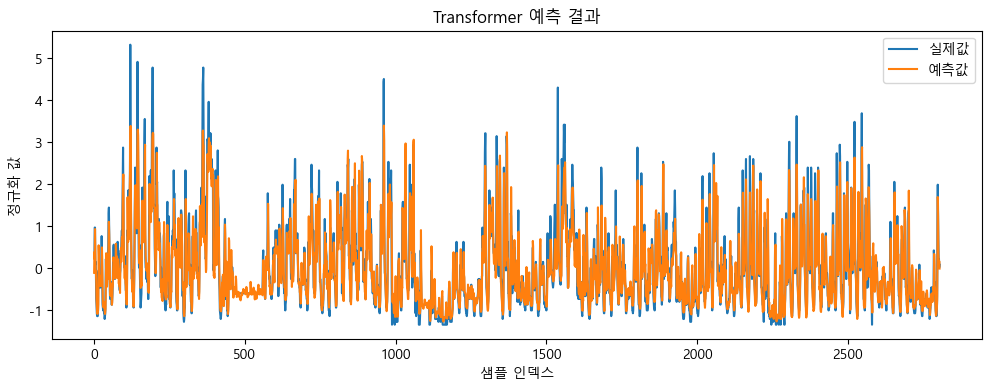

In [26]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# (옵션) 예측 결과 시각화
plt.figure(figsize=(12,4))
plt.plot(transformer_targets, label='실제값')
plt.plot(transformer_preds, label='예측값')
plt.xlabel('샘플 인덱스')
plt.ylabel('정규화 값')
plt.title('Transformer 예측 결과')
plt.legend()
plt.show()

# 결과 해석

### 예측 모델(Transformer)
**학습 과정:**
- 10 에포크 동안 Transformer 기반 모델의 학습 손실이 0.4311에서 0.1945로 감소하였습니다.
- 이는 모델이 학습 데이터의 시계열 패턴을 효과적으로 학습했음을 의미합니다.

**평가 결과:**
- RMSE 약 0.4345, MAE 약 0.2928, 결정계수(R²) 약 0.8115로, 기존 LSTM 모델과 유사한 예측 성능을 보였습니다.
- 예측 성능 지표가 안정적인 수준으로 나타나, Transformer 모델이 시계열 예측에도 적합하다는 점을 시사합니다.

### 이상치 감지(VAE 기반)
**VAE 학습:**
- VAE 모델은 20 에포크 동안 전체 손실(재구성 손실 + KLD)이 점진적으로 감소하였으며, 초기 2259.18에서 최종 1574.30 정도로 낮아졌습니다.
- 단, 학습 과정 중 재구성 손실 계산 시 입력과 타겟의 크기가 다르다는 경고가 나타났는데, 이는 평탄화 과정에서 크기 정합성을 다시 한 번 확인할 필요가 있음을 의미합니다.

**이상치 탐지 결과:**
- 학습 데이터 기준으로 6542개의 이상치가 감지되었고, 실시간 스트리밍 시뮬레이션에서는 2805개의 이상치가 탐지되었습니다.
- 재구성 오차가 매우 큰 값(예: 8~36 이상의 값)이 다수 관측되었는데, 이는 설정한 임계치(0.5)가 실제 VAE의 재구성 오차 분포에 비해 너무 낮은 것으로 보입니다.

**해석:**
- VAE의 재구성 손실 수치가 크기 때문에, 임계치를 도메인 데이터에 맞게 재조정하거나, 정상 데이터의 오차 분포를 분석하여 적절한 기준을 재설정하는 작업이 필요합니다.
- 실제 운영 환경에서는 도메인 전문가의 피드백과 함께 False Positive를 줄이기 위한 후처리 및 임계치 최적화가 요구됩니다.